# Install Dependencies

If you work with a Windows machine, it's better to try LayoutParser on Google Colab instead since it's tricky to install Detectron 2 on Windows machine

In [3]:

# !sudo apt-get install poppler-utils #pdf2image dependency -- restart runtime/kernel after installation
# !sudo apt-get install tesseract-ocr-eng #install Tesseract OCR Engine --restart runtime/kernel after installation

[sudo] password for danny: 

In [ ]:
# %pip install layoutparser torchvision && pip install "detectron2@git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"
# %pip install pdf2img
# %pip install "layoutparser[ocr]"

In [2]:
import pdf2image
import numpy as np
import layoutparser as lp
import torchvision.ops.boxes as bops
import torch
import fitz

# Layout Detection 

In [3]:
file_path= './img/ninja.pdf' # Adjust the filepath of your input image accordingly
doc = fitz.open(file_path)  # open document

# Get the 25th page of the document
page = doc[24]
pix = page.get_pixmap(dpi=150) 
img = np.frombuffer(buffer=pix.samples, dtype=np.uint8).reshape((pix.height, pix.width, -1))
# img = np.asarray(pdf2image.convert_from_path(pdf_file)[0])

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


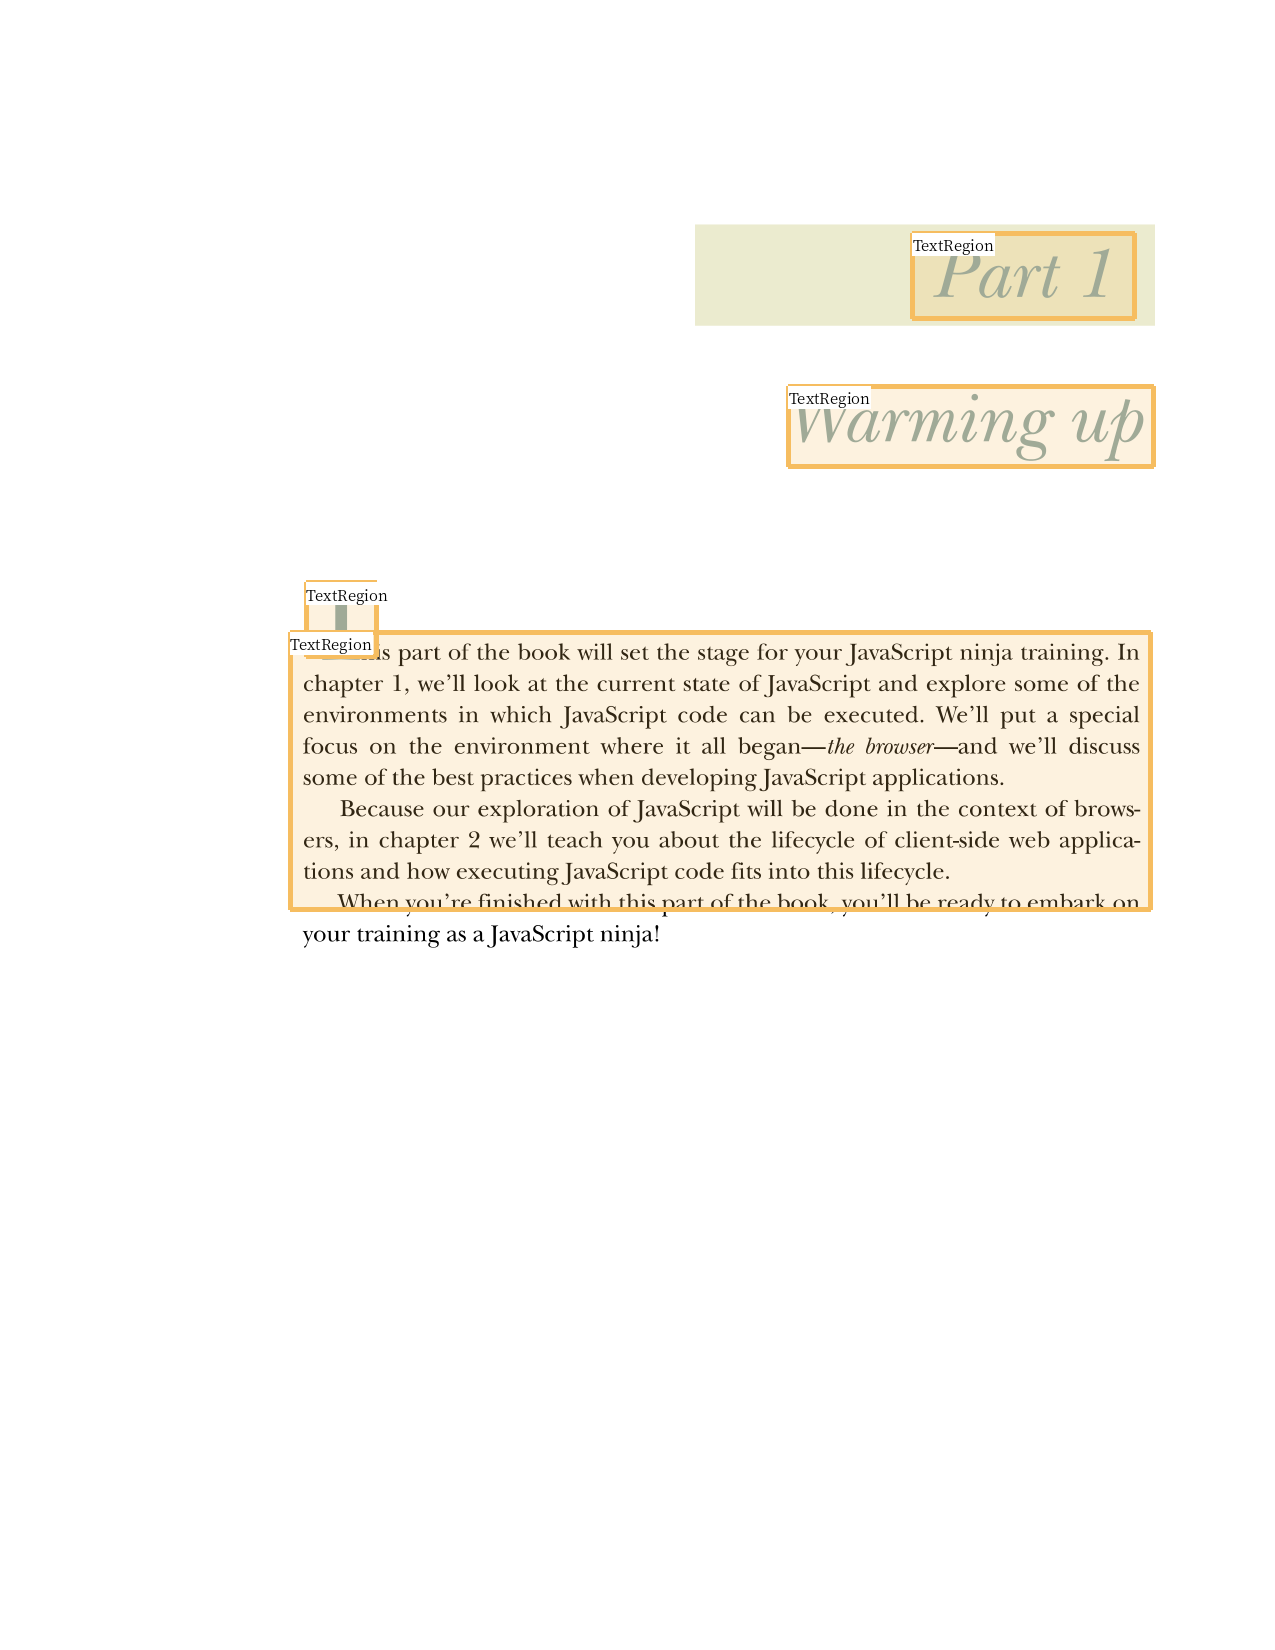

In [12]:
model = lp.Detectron2LayoutModel('lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
                                 label_map={1:"TextRegion", 2:"ImageRegion", 3:"TableRegion", 4:"MathsRegion", 5:"SeparatorRegion", 6:"OtherRegion"})
layout = model.detect(img) # You need to load the image somewhere else, e.g., image = cv2.imread(...)

lp.draw_box(img, layout,  box_width=5, box_alpha=0.2, show_element_type=True)

In [ ]:
text_blocks = lp.Layout([b for b in layout_result if b.type=='Text'])

lp.draw_box(img, text_blocks,  box_width=5, box_alpha=0.2, show_element_type=True, show_element_id=True)

# OCR Parser with Tesseract

In [ ]:
ocr_agent = lp.TesseractAgent(languages='eng')

In [ ]:
image_width = len(img[0])

# Sort element ID of the left column based on y1 coordinate
left_interval = lp.Interval(0, image_width/2, axis='x').put_on_canvas(img)
left_blocks = text_blocks.filter_by(left_interval, center=True)._blocks
left_blocks.sort(key = lambda b:b.coordinates[1])

# Sort element ID of the right column based on y1 coordinate
right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# Sort the overall element ID starts from left column
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

lp.draw_box(img, text_blocks,  box_width=5, box_alpha=0.2, show_element_type=True, show_element_id=True)

In [ ]:
for block in text_blocks:

    # Crop image around the detected layout
    segment_image = (block
                       .pad(left=15, right=15, top=5, bottom=5)
                       .crop_image(img))
    
    # Perform OCR
    text = ocr_agent.detect(segment_image)

    # Save OCR result
    block.set(text=text, inplace=True)

In [ ]:
for txt in text_blocks:
    print(txt.text, end='\n---\n')

# Adjusting LayoutParser Result

In [ ]:
pdf_file_2= '/img/doc_2.pdf' # Adjust the filepath of your input image accordingly
img_2 = np.asarray(pdf2image.convert_from_path(pdf_file)[0])

In [ ]:
layout_result_2 = model.detect(img_2)

text_blocks_2 = lp.Layout([b for b in layout_result_2 if b.type=='Text'])

lp.draw_box(img_2, text_blocks_2,  box_width=5, box_alpha=0.2, show_element_type=True, show_element_id=True)

In [ ]:
def set_coordinate(data):

  x1 = data.block.x_1
  y1 = data.block.y_1
  x2 = data.block.x_2
  y2 = data.block.y_2

  return torch.tensor([[x1, y1, x2, y2]], dtype=torch.float)

def compute_iou(box_1, box_2):

  return bops.box_iou(box_1, box_2)

def compute_area(box):

    width = box.tolist()[0][2] - box.tolist()[0][0]
    length = box.tolist()[0][3] - box.tolist()[0][1]
    area = width*length

    return area

def refine(block_1, block_2):

  bb1 = set_coordinate(block_1)
  bb2 = set_coordinate(block_2)

  iou = compute_iou(bb1, bb2)

  if iou.tolist()[0][0] != 0:

    a1 = compute_area(bb1)
    a2 = compute_area(bb2)

    block_2.set(type='None', inplace= True) if a1 > a2 else block_1.set(type='None', inplace= True)
    

for layout_i in text_blocks_2:
  
    for layout_j in text_blocks_2:
      
        if layout_i != layout_j: 

            refine(layout_i, layout_j)
            
text_blocks_2 = lp.Layout([b for b in text_blocks_2 if b.type=='Text'])

lp.draw_box(img_2, text_blocks_2,  box_width=5, box_alpha=0.2, show_element_type=True, show_element_id=True)

In [ ]:
text_blocks_2 = lp.Layout([b.set(id = idx) for idx, b in enumerate(text_blocks_2)])

# From the visualization, let's say we know that layout 
# with 'Diameter Thickness' text has element ID of 4

text_blocks_2[4].set(type='None', inplace=True)
text_blocks_2 = lp.Layout([b for b in text_blocks_2 if b.type=='Text'])

lp.draw_box(img_2, text_blocks_2,  box_width=5, box_alpha=0.2, show_element_type=True, show_element_id=True)